# Dictionary Analysis

The second method uses dictionary analysis to identify and count comments from lateral thinkers. The dictionary analysis is a very simple method and is derived from sentiment analysis. Due to the simplicity of the model, the results must be critically examined and questioned at the end. For example, due to the bag-of-words representation in the model, we cannot take negations into account, which can lead to misleading results.

The dictionary used is the RPX-Lex dictionary, which was developed to measure german right-wing populist conspiracy discourse {cite:p}`rpc_lex_dictionary`. The dictionary contains 14,105 terms which are divided into 13 categories, such as Suspicion, Antisemitism or Esotericism {cite:p}`rpc_lex_dictionary`. It should be noted, that some terms appear in more than one category, as they are assigned to several categories. This circumstance will be taken into account later in the analysis so that hits are not counted twice.

First, we load the dictionary and as we can see, it contains 14,105 terms as stated in the paper.

In [ ]:
import pandas as pd
from cleantext import clean
from tqdm import tqdm

In [3]:
rpx_dict = pd.read_csv("dictionary_analysis/rpc_lex.csv", delimiter=";")
display(rpx_dict[["term", 'category_en']])

,term,category_en
0,-etage,Scandalization
1,#abgase,Scandalization
2,#kreuzfahrtschiffe,Scandalization
3,#schwerölverbrennung,Scandalization
4,#umweltskandal,Scandalization
...,...,...
14100,wurzelrassenlehre,Esotericism
14101,z-plan,Esotericism
14102,zahlenmystik,Esotericism
14103,zeitenwende,Esotericism


In [8]:
def get_dictionary_analysis_term_occurence(text: str):
    term_occurrence = 0
    identified_terms = []
    text_tokens = set(text.split(" "))
    for term in rpx_dict.term.to_list():
        if term in identified_terms:
            continue # Skip terms that have already been identified but occur in multiple categories

        if " " in term:
            if term in text: # Dictionary term consists of several words
                term_occurrence+=1
                identified_terms.append(term)
        else:
            if term in text_tokens: # Dictionary term is a single word
                term_occurrence+=1
                identified_terms.append(term)
    return term_occurrence, identified_terms

In [6]:
comments_df = pd.read_csv("data/youtube_comments_500.csv")
comments_df["Comments"] = comments_df["Comments"].astype(str)

def clean_text(text:str):
    text = clean(text, no_emoji=True, lang="de")
    new_text = []
    for token in text.split(" "):
        if not token.startswith('@') and not token.startswith('http'):
            new_text.append(token)
    return " ".join(new_text)

comments_df["Comments"] = comments_df["Comments"].apply(lambda text: clean_text(text))
comments_df = comments_df[comments_df.Comments != ""]

In [9]:
dict_term_occurrence_list = []
dict_identified_terms_list = []

for text in tqdm(comments_df.Comments.to_list()):
    occurrence_counter, identified_terms_list = get_dictionary_analysis_term_occurence(text)
    dict_term_occurrence_list.append(occurrence_counter)
    dict_identified_terms_list.append(identified_terms_list)

comments_df["dict_term_occurrence"] = dict_term_occurrence_list
comments_df["dict_identified_terms_list"] = dict_identified_terms_list

100%|██████████| 401282/401282 [07:11<00:00, 930.61it/s] 


In [20]:
display(comments_df.loc[comments_df['dict_term_occurrence'] > 0])

,Unnamed: 0,Comments,dict_term_occurrence,dict_identified_terms_list
0,0,wollt ihr jetzt jeden tag einen großen bericht...,7,"[ganz, großen, bericht, schön, panzer, sinnlos..."
1,1,"wenn scholz alles besser weiss, wieso braucht ...",3,"[braucht, wieso, besser]"
2,2,die grünen hatten früher das peace zeichen als...,9,"[grünen, heute, militär, panzer, wächst, frühe..."
3,3,der westen ist ein kriegstreiber bis es zu ein...,6,"[kommt, lange, idioten, kriegstreiber, westen,..."
4,4,frieden schaffen ohne waffen.,2,"[schaffen, frieden]"
...,...,...,...,...
406236,406236,"was die union wieder will, die leute sind doch...",10,"[land, leute, sollen, sowieso, wäre, brauchen,..."
406237,406237,"kann jeder deutscher werden ,kein problem sola...",9,"[gehen, deutsche, überwacht, irgendwelche, arb..."
406238,406238,dann nimm die leute bei dir auf und verpflege ...,1,[leute]
406239,406239,als staatenloser hatt mans aber auch nicht lei...,1,[stimmt]


array([[<AxesSubplot: title={'center': 'dict_term_occurrence'}>]],
      dtype=object)

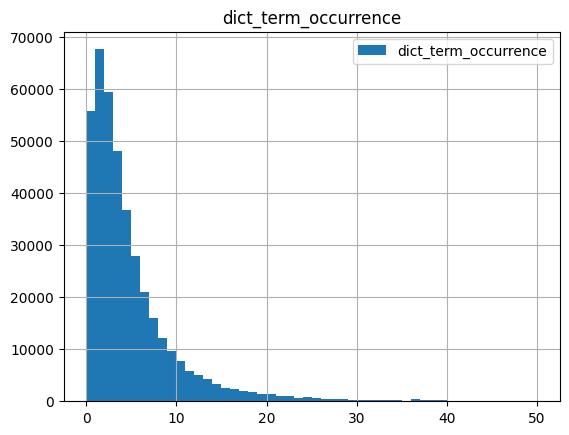

In [16]:
comments_df.hist(column="dict_term_occurrence", legend=True, bins=50, range=[0,50])

In [33]:
display(comments_df.loc[comments_df['dict_term_occurrence'] > 4])

,Unnamed: 0,Comments,dict_term_occurrence,dict_identified_terms_list
0,0,wollt ihr jetzt jeden tag einen großen bericht...,7,"[ganz, großen, bericht, schön, panzer, sinnlos..."
2,2,die grünen hatten früher das peace zeichen als...,9,"[grünen, heute, militär, panzer, wächst, frühe..."
3,3,der westen ist ein kriegstreiber bis es zu ein...,6,"[kommt, lange, idioten, kriegstreiber, westen,..."
7,7,"donnor, beweis deine behauptung, die ukraine w...",5,"[deutschland, beweis, ukraine, wagenknecht, so..."
10,10,der fraktionslose bundestagsabgeordnete robert...,12,"[eigenen, geht, politische, traut, dabei, klar..."
...,...,...,...,...
406222,406222,und außerdem kann sich jeder im krankenhaus be...,5,"[kohle, lassen, völlig, sachen, außer]"
406223,406223,du hast es nicht verstanden junge ..\ndie ampe...,7,"[deutschland, junge, hast, leben, arbeiten, eu..."
406233,406233,deutschland hat fertig!\nausbildung fehlanzeig...,5,"[deutschland, gerne, unsere, bestimmt, rentner]"
406236,406236,"was die union wieder will, die leute sind doch...",10,"[land, leute, sollen, sowieso, wäre, brauchen,..."


In [44]:
for index, values in comments_df.loc[comments_df['dict_term_occurrence'] > 4].sample(10)[["Comments", "dict_identified_terms_list"]].iterrows():
    print(f"Sample {index+1}: {values['dict_identified_terms_list']}\n")
    print(values["Comments"])
    print("-"*150)

Sample 398335: ['politik', 'presse', 'stimmt', 'handlanger', 'meint']

wenn auf einen in gewahrsam genommenen reichsbürger-rentner vier journalisten kommen, dann:
a) stimmt die gewaltenteilung
b) ist es eine farce
c) ist die presse handlanger der politik geworden
was meint ihr?
------------------------------------------------------------------------------------------------------------------------------------------------------
Sample 178360: ['wenig', 'wie', 'ebenso', 'gehören', 'schwäche', 'deutscher']

metalhead kulturbanausen, die meinen, ihre schwäche durch kraft- und fäkalausdrücke kompensieren zu müssen, gehören ebenso wenig zu einer kulturnation, wie barbaren, die in der genuss verschleuderter deutscher staatsbürgerschaften kommen.
------------------------------------------------------------------------------------------------------------------------------------------------------
Sample 361514: ['vollkommen', 'bringen', 'konstruiert', 'staatlichen', 'selbstredend', 'illegalen', '

In [45]:
for index, values in comments_df.loc[comments_df['dict_term_occurrence'] > 10].sample(10)[["Comments", "dict_identified_terms_list"]].iterrows():
    print(f"Sample {index+1}: {values['dict_identified_terms_list']}\n")
    print(values["Comments"])
    print("-"*150)

Sample 242548: ['deutschland', 'dummheit', 'eigentlich', 'glück', 'komplett', 'reine', 'reiner', 'beim', 'wie', 'seid', 'aufgrund', 'soviel', 'studierte', 'sucht', 'sieg', 'konsequenzen', 'neben']

wm - aus
nun sucht ihr also einen schuldigen am wm- ausschied.... personelle konsequenzen aufgrund eines spiels bei dem neben komplett unbedeutsamen nebensachlichkeiten bloss das reine glück auf einen sieg erforderlich ist ? ist das euer ernst? sagt, wie trivial seid ihr eigentlich ??? wir haben soviel abiturienten beim dfb und bundesweit soviel studierte menschen, doch wie kann es sein, dass deutschland inzwischen an reiner dummheit nicht mehr zu überbieten ist ???
------------------------------------------------------------------------------------------------------------------------------------------------------
Sample 225632: ['denkt', 'ganze', 'jemand', 'kommt', 'zwei', 'quasi', 'wie', 'wann', 'lieben', 'guten', 'liebe', 'mittelstand', 'stammt', 'china']

guten abend, ihr lieben menschen